In [1]:
using Turing
using DataFrames
using CSV
using Random
using Distributions
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using Logging
using LinearAlgebra

default(label=false);
Logging.disable_logging(Logging.Warn);

Code 15.1

In [2]:
Random.seed!(2)

function sim_pancake()
    pancake = [[1, 1], [1, 0], [0, 0]]
    sides = sample(pancake)
    sample([sides, reverse(sides)])
end

pancakes = vcat([sim_pancake() for _ in 1:10_000]'...)
up = pancakes[:,1]
down = pancakes[:,2]

num_11_10 = sum(up .== 1)
num_11 = sum((up .== 1) .& (down .== 1))
num_11 / num_11_10

0.6619385342789598

# 15.1 Measurement error

Code 15.2

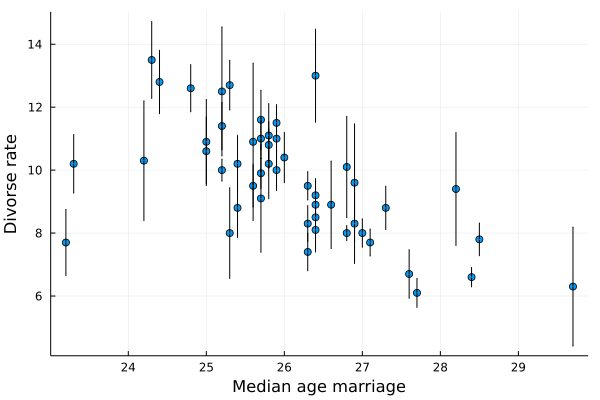

In [3]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))

scatter(d.MedianAgeMarriage, d.Divorce, xlab="Median age marriage", ylab="Divorse rate")
scatter!(d.MedianAgeMarriage, d.Divorce, yerror=d."Divorce SE", ms=0)

Code 15.3

In [4]:
dlist = (
    D_obs = standardize(ZScoreTransform, d.Divorce),
    D_sd = d."Divorce SE" ./ std(d.Divorce),
    M = standardize(ZScoreTransform, d.Marriage),
    A = standardize(ZScoreTransform, d.MedianAgeMarriage),
    N = nrow(d),
)

@model function m15_1(D_obs, D_sd, M, A, N)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    σ ~ Exponential()
    D_true ~ MvNormal(μ, σ)
    @. D_obs ~ Normal(D_true, D_sd)
end

Random.seed!(1)
m15_1_ch = sample(m15_1(dlist...), NUTS(), 1000)
m15_1_df = DataFrame(m15_1_ch);

Code 15.4

In [5]:
precis(m15_1_df)

┌────────────┬────────────────────────────────────────────────────────────┐
│      param │    mean     std     5.5%      50%    94.5%       histogram │
├────────────┼────────────────────────────────────────────────────────────┤
│ D_true[10] │  -0.621   0.173  -0.8887  -0.6122  -0.3597    ▁▁▂▄▆▇█▆▃▁▁▁ │
│ D_true[11] │  0.7624  0.2994    0.305   0.7637   1.2305     ▁▁▁▃▆██▅▂▁▁ │
│ D_true[12] │ -0.5211  0.5113  -1.3393  -0.5269   0.2834         ▁▄██▃▁▁ │
│ D_true[13] │  0.1502  0.4773  -0.6217   0.1682   0.9289         ▁▁▂▆█▄▁ │
│ D_true[14] │ -0.8638  0.2135  -1.1956  -0.8584  -0.5373        ▁▁▂▅█▇▂▁ │
│ D_true[15] │  0.5593   0.293   0.1014   0.5529   1.0363     ▁▁▁▃▅██▄▂▁▁ │
│ D_true[16] │  0.2798  0.3782  -0.3492   0.2904   0.8596         ▁▁▄█▅▁▁ │
│ D_true[17] │  0.4957  0.4189  -0.1862   0.5133   1.1655          ▁▃██▂▁ │
│ D_true[18] │   1.238  0.3584   0.6892   1.2332   1.8434     ▁▂▃▆██▇▃▂▁▁ │
│ D_true[19] │  0.4156  0.3715  -0.1677   0.4065   0.9925  ▁▁▂▃▆██▆▄▂▁▁▁▁ │
│  D_true[1]

Code 15.5

In [6]:
dlist = (
    D_obs = standardize(ZScoreTransform, d.Divorce),
    D_sd = d."Divorce SE" ./ std(d.Divorce),
    M_obs = standardize(ZScoreTransform, d.Marriage),
    M_sd = d."Marriage SE" ./ std(d.Marriage),
    A = standardize(ZScoreTransform, d.MedianAgeMarriage),
    N = nrow(d),
)

@model function m15_2(D_obs, D_sd, M_obs, M_sd, A, N)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    M_true ~ filldist(Normal(), N)
    
    μ = @. a + bA * A + bM * M_true
    σ ~ Exponential()
    D_true ~ MvNormal(μ, σ)
    @. D_obs ~ Normal(D_true, D_sd)
    @. M_obs ~ Normal(M_true, M_sd)
end

Random.seed!(1)
m15_2_ch = sample(m15_2(dlist...), NUTS(), 1000)
m15_2_df = DataFrame(m15_2_ch);

Code 15.6

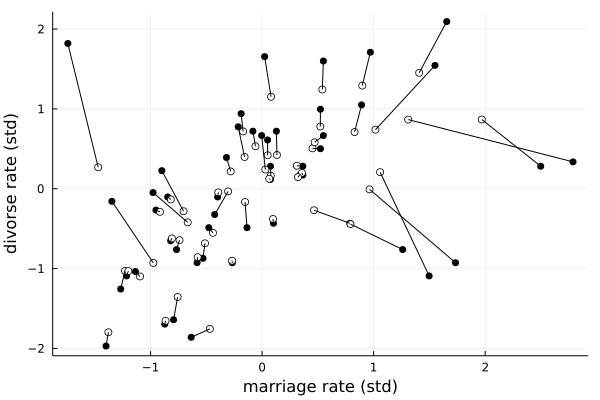

In [7]:
D_true = [mean(m15_2_df[!, "D_true[$i]"]) for i ∈ 1:dlist.N]
M_true = [mean(m15_2_df[!, "M_true[$i]"]) for i ∈ 1:dlist.N]

p = scatter(dlist.M_obs, dlist.D_obs, mc=:black, xlab="marriage rate (std)", ylab="divorse rate (std)")
scatter!(M_true, D_true, mc=:white)

for i ∈ 1:dlist.N
    plot!([dlist.M_obs[i], M_true[i]], [dlist.D_obs[i], D_true[i]], c=:black)
end
p

Code 15.7

In [9]:
N = 500
A = rand(Normal(), N)
M = rand.(Normal.(-A))
D = rand.(Normal.(A))
A_obs = rand.(Normal.(A));

# 15.2 Missing data